In [2]:
#Training the model on 30k datasets.

import random
import numpy as np
from Bio import SeqIO
import gzip
import os
import pickle
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

#Set random seeds for reproducibility.
np.random.seed(4)
random.seed(5)
set_random_seed(4) 



def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X


def get_positive_samples(protein, t_data, training_set_number, *args ):
    data_sources, X_test = load_data_sources(protein, t_data, training_set_number, *args)
    y_test = get_class(protein, t_data, training_set_number)
    y_test = y_test [:,1]
    positive_samples = np.zeros((2000, X_test.shape[1], X_test.shape[2]))
    n = 0

    for i, value in enumerate(y_test):
        if value == 1:
            positive_samples[n] = X_test[i]
            n += 1 
 
    return positive_samples


In [ ]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
from keras.models import model_from_json

# Sum of gradients across all layers saved under protein name.
gradients_dict = {}

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))


        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)
        

        layer_index = 0
        protein_grads = np.zeros((12,101))

        for layer in model.layers:
            print (layer)

            #Swap softmax with linear
            model.layers[layer_index].activation = activations.linear
            model = utils.apply_modifications(model)

            grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=X_test)

            protein_grads[layer_index,:] = grads

            plt.figure(1)
            plt.subplot(12,1,layer_index+1, xticks = np.arange(-50,50,10), yticks = [])    
            plt.imshow(grads.reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')

            layer_index += 1

        plt.figure(1)
        plt.show()
        plt.close()
        
        grads_total = np.sum(protein_grads, axis = 0)
        gradients_dict[protein] = grads_total
        
        plt.figure(2)
        plt.subplot(211, xticks=np.arange(0,101,10), yticks=[])
        plt.imshow(grads_total.reshape((1,-1)), aspect='auto', cmap='jet', interpolation='nearest')
        plt.show()
        plt.close()



In [ ]:
import h5py
from keras import activations
from keras.models import model_from_json
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
import time

protein_list = ["1_PARCLIP_AGO1234_hg19"]#, 2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']


data_sources, X_test = load_data_sources("1_PARCLIP_AGO1234_hg19","test",0,*experiment_set)
y_test = get_class("1_PARCLIP_AGO1234_hg19","test",0)
y_test = y_test [:,1]
positive_samples = np.zeros((2000, X_test.shape[1], X_test.shape[2]))

n = 0

for i in range (len(y_test)):
    if y_test[i] == 1:
        positive_samples[n] = X_test[i]
        n += 1 
        #positive_samples = np.array(positive_samples)  


for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Create a new set for a protein in h5py file  
        with h5py.File("results/set_0/test", "w") as f:
            dset = f.create_dataset(protein, dtype="f", shape=(0, 101) , maxshape=(None, 101), chunks=(1, 101))

        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))

            for layer_index, layer in enumerate(model.layers):
                #Swap softmax with linear
                model.layers[layer_index].activation = activations.linear
                model = utils.apply_modifications(model)

            for example in range (100):
                time1 = time.time()
                layer_index = 0
                protein_grads = np.zeros((12,101))
                seed_input = positive_samples[example,:,:]


                with h5py.File("results/set_0/test", "a") as f:
                    for layer_index, layer in enumerate(model.layers):

                        #Calculate saliency
                        grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=seed_input)
                        protein_grads[layer_index,:] = grads
                        #layer_index += 1

                    grads_sum = sum(protein_grads)



                    #Append sum of saliency over all layers 
                    dset = f[protein]
                    dset.resize((example + 1, 101,))
                    dset[example] = grads_sum
                    time2 = time.time()
                    
                    
                    print('{} function took {} ms'.format(example, (time2-time1)*1000.0))
                    
                
                    
                 

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

gradient_array = []
for protein in protein_list:
    gradient_array.append(gradients_dict.get(protein))

Z = linkage(gradient_array, 'ward')
fig = plt.figure(figsize=(10, 10))
dn = dendrogram(Z, orientation = 'left')
plt.show()



In [ ]:
import h5py


with h5py.File("results/set_0/test", "w") as f:
    dset = f.create_dataset(protein, dtype="f", shape=(0, 101) , maxshape=(None, 101), chunks=(1, 101))



In [ ]:
i = 0
values = np.zeros(101)
with h5py.File("mytestfile.hdf5", "a") as f:
            dset = f["set1"]
            dset.resize((i + 1, 101,))
            dset[i] = values
            i += 1

In [8]:
with h5py.File("results/set_0/test", "r") as f:
    dset = f[protein]
    print(dset)

<HDF5 dataset "1_PARCLIP_AGO1234_hg19": shape (10, 101), type "<f4">


In [ ]:
#Categorical Dense layer visualization

import h5py
from keras import activations
from keras.models import model_from_json
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
import time
import gc


def get_positive_samples(protein, t_data, training_set_number, *args ):
    data_sources, X_test = load_data_sources(protein, t_data, training_set_number, *args)
    y_test = get_class(protein, t_data, training_set_number)
    y_test = y_test [:,1]
    positive_samples = np.zeros((2000, X_test.shape[1], X_test.shape[2]))
    n = 0

    for i, value in enumerate(y_test):
        if value == 1:
            positive_samples[n] = X_test[i]
            n += 1 
 
    return positive_samples


def append_to_h5py(protein, example, grads_sum):
    with h5py.File("results/set_0/test", "a") as f:
        #Append sum of saliency over all layers 
                    dset = f[protein]
                    dset.resize((example + 1, 101,))
                    dset[example] = grads_sum


def swap_activtion (protein, training_set_number):
    with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
        json = json_file.read()
        model = model_from_json(json)
        model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
        
        for layer_index, layer in enumerate(model.layers):
            #Swap softmax with linear
            model.layers[layer_index].activation = activations.linear
            model = utils.apply_modifications(model)
    
    return model


def save_saliency(protein, training_set_number, example, seed_input, model):
        layer_index = -1

        #Calculate saliency
        grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=seed_input)
        append_to_h5py(protein, example, grads)
'''        
def save_saliency(protein, training_set_number, example, seed_input, model):

        protein_grads = np.zeros((12,101))

        for layer_index, layer in enumerate(model.layers):

            #Calculate saliency
            grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=seed_input)
            protein_grads[layer_index,:] = grads

        grads_sum = sum(protein_grads)
        append_to_h5py(protein, example, grads_sum)  
'''    
        
protein_list = ["1_PARCLIP_AGO1234_hg19"]#, 2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
training_set_number = 0
protein = "1_PARCLIP_AGO1234_hg19"
        
positive_samples = get_positive_samples(protein,"test", training_set_number, *experiment_set)

#Create a new set for a protein in h5py file  
with h5py.File("results/set_0/test", "w") as f:
    dset = f.create_dataset(protein, dtype="f", shape=(0, 101) , maxshape=(None, 101), chunks=(1, 101))

model = swap_activtion (protein, training_set_number)

for example, seed_input in enumerate(positive_samples):
    time1 = time.time()
    save_saliency(protein, training_set_number, example, seed_input, model) 
    time2 = time.time()

    print('{} function took {} s'.format(example, (time2-time1)))
    gc.collect()



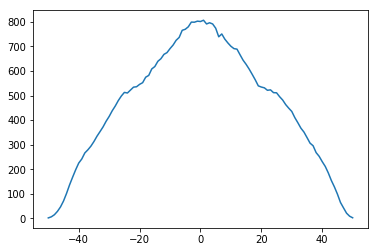

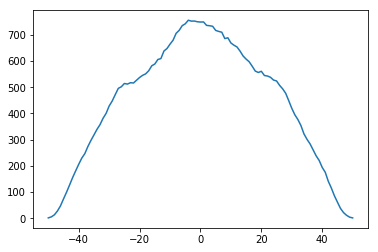

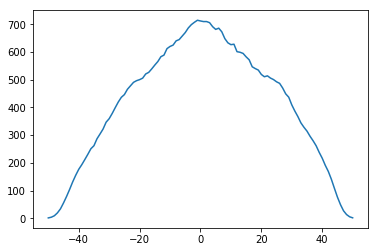

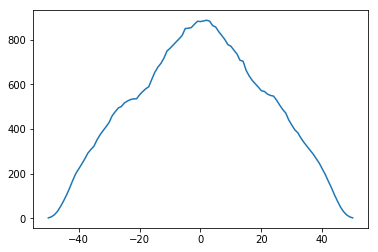

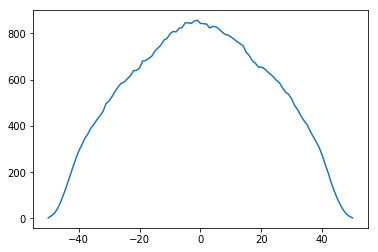

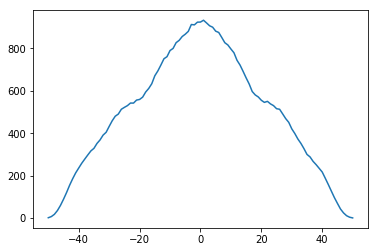

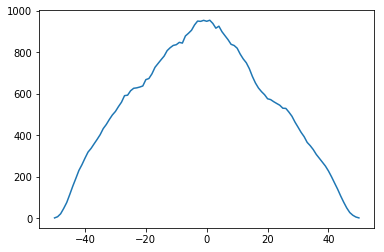

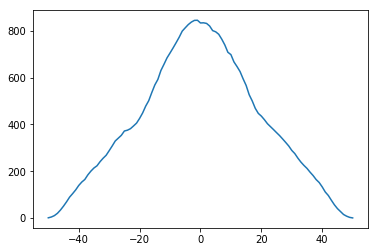

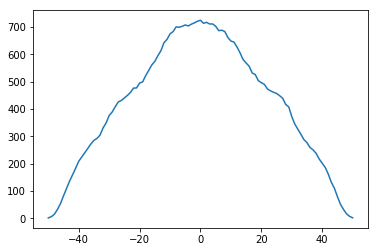

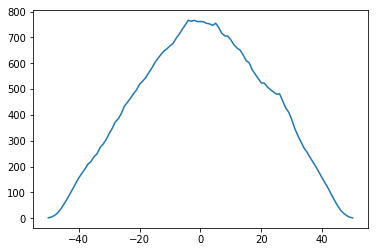

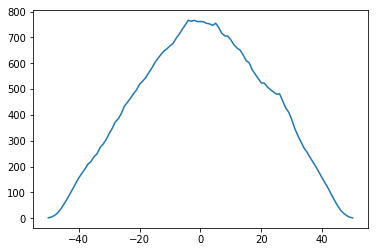

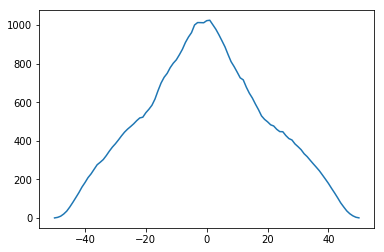

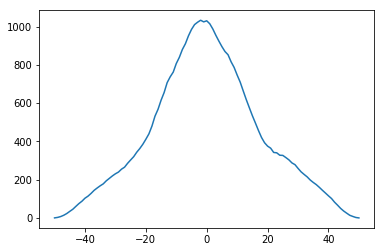

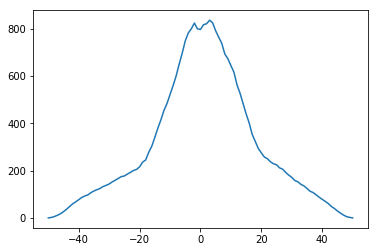

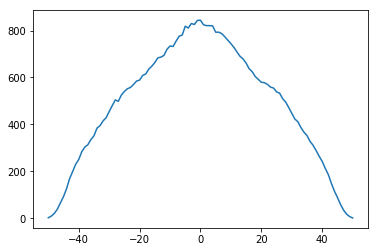

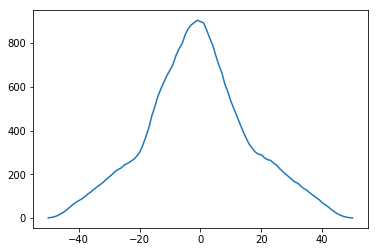

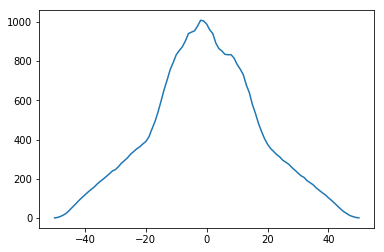

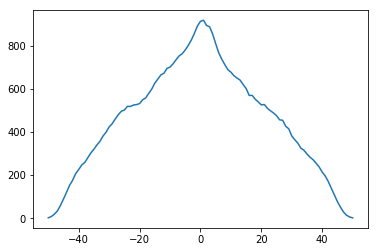

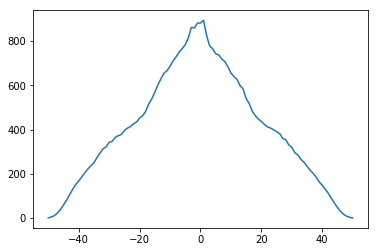

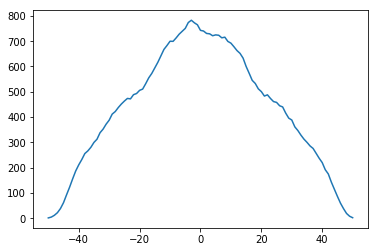

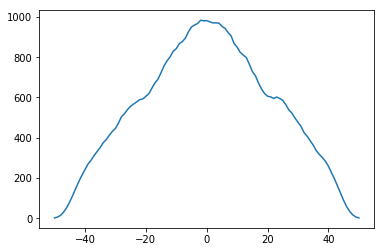

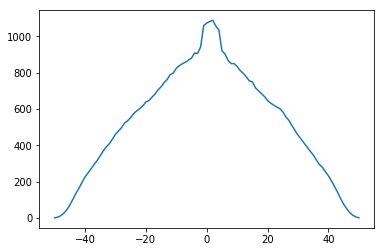

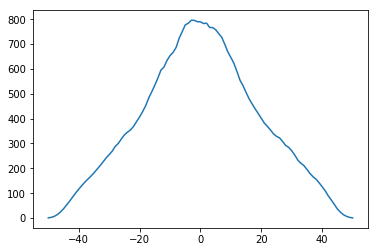

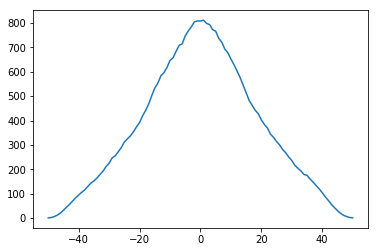

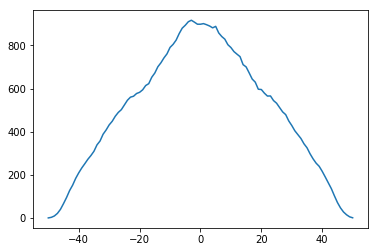

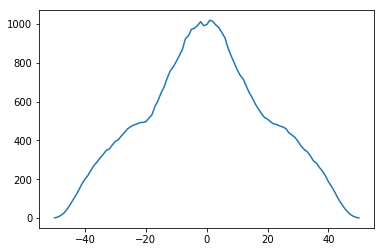

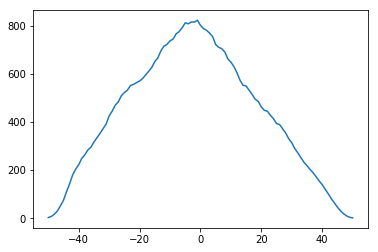

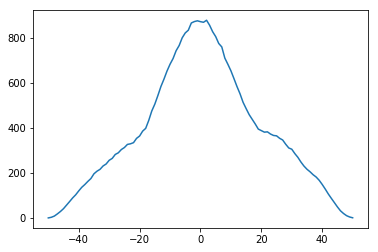

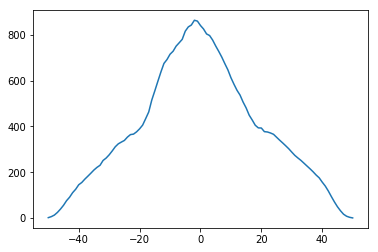

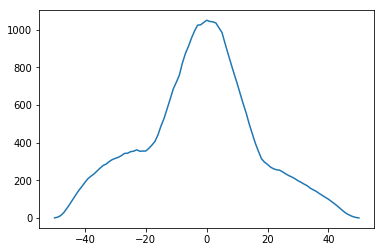

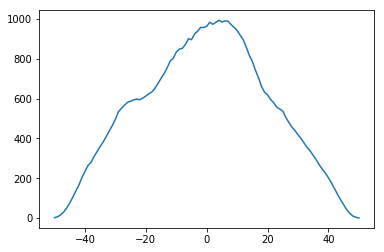

In [5]:
import h5py
# protein = "17_ICLIP_HNRNPC_hg19"
for protein in protein_list:
    with h5py.File("results/set_0/{}/saliency.h5".format(protein), "r") as f:
        dset = f[protein]
        plt.plot(np.arange(-50,51),sum(dset))
        plt.show()
#     for i, entry in enumerate(dset):
#         plt.plot(np.arange(-50,51), entry)
#         plt.xlabel('Position relative to cross-link site')
#         plt.ylabel('Normalized influence on the score')
#         plt.show()
#     sum(dset)

In [3]:
#Saliency motifs generated on saliency of whole positive data set for each protein.
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
import h5py

def onehot_to_seq(encoded_sequence):
    nucleotide = {0 : 'A', 1 : 'U', 2 : 'G', 3 : 'C'}
    sequence = []
    for entry in encoded_sequence:
        i = 0
        for nuc in entry:
            if nuc == 1:
                sequence.append(nucleotide[i])
            i += 1  
    return sequence

# Sum of gradients across all layers saved under protein name.

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
training_set_number = 0

for protein in protein_list:
    # Load the saliency gradients dictionary for all the proteins.
    with h5py.File("results/set_0/{}/saliency.h5".format(protein), "r") as f:
        dataset = f[protein]
        positive_samples = get_positive_samples(protein,"test", training_set_number, *experiment_set)
        print (dataset)


        for f, grad in enumerate (dataset):
            if sum(grad) != 0:
                # print(f)
                #Find the window of 7 nucletides with the highest sailency using highest sum as a measure.
                n = 101
                window_size = 7 
                max_saliency_sum = 0

                # calculate sum of elements in the first window
                for i in range(window_size): 
                    #print(grad[i])
                    max_saliency_sum += grad[i]
                    #print(max_saliency_sum)

                curr_sum = max_saliency_sum 
                position = 7
                # calculate sum for each next position by adding the value of current position and removing the value of the first position of previous window. Position is the index of the last element that gives highest sum.
                for i in range(window_size, n): 

                    curr_sum += grad[i] - grad[i-window_size] 
                    #print (curr_sum)
                    if curr_sum > max_saliency_sum:
                        position = i 
                    max_saliency_sum = max(max_saliency_sum, curr_sum)

                seed_input = positive_samples[f,:,:]
                #print (position)
                #print (seed_input)

                # After obtainig the position value of the last nucleotide in the 7 nucleotides window, we extract features from the input matrix.
                highest_saliency_motif = [ seed_input[i,:] for i in range(position-7,position)]
                oh_motif = np.array(highest_saliency_motif)[:, 0:4]
                motif_seq = onehot_to_seq(oh_motif)

                with open ("results/set_%s/%s/saliency_motifs.txt" % (training_set_number, protein), "a") as motif_file:
                    motif_file.write('{}\t{}\n'.format(f+1, ''.join(motif_seq)))




<HDF5 dataset "1_PARCLIP_AGO1234_hg19": shape (2000, 101), type "<f4">
<HDF5 dataset "2_PARCLIP_AGO2MNASE_hg19": shape (2000, 101), type "<f4">
<HDF5 dataset "3_HITSCLIP_Ago2_binding_clusters": shape (2000, 101), type "<f4">
<HDF5 dataset "4_HITSCLIP_Ago2_binding_clusters_2": shape (2000, 101), type "<f4">
<HDF5 dataset "5_CLIPSEQ_AGO2_hg19": shape (2000, 101), type "<f4">
<HDF5 dataset "6_CLIP-seq-eIF4AIII_1": shape (2000, 101), type "<f4">
<HDF5 dataset "7_CLIP-seq-eIF4AIII_2": shape (2000, 101), type "<f4">
<HDF5 dataset "8_PARCLIP_ELAVL1_hg19": shape (2000, 101), type "<f4">
<HDF5 dataset "9_PARCLIP_ELAVL1MNASE_hg19": shape (2000, 101), type "<f4">
<HDF5 dataset "10_PARCLIP_ELAVL1A_hg19": shape (2000, 101), type "<f4">
<HDF5 dataset "10_PARCLIP_ELAVL1A_hg19": shape (2000, 101), type "<f4">
<HDF5 dataset "12_PARCLIP_EWSR1_hg19": shape (2000, 101), type "<f4">
<HDF5 dataset "13_PARCLIP_FUS_hg19": shape (2000, 101), type "<f4">
<HDF5 dataset "14_PARCLIP_FUS_mut_hg19": shape (2000, 101

1_PARCLIP_AGO1234_hg19


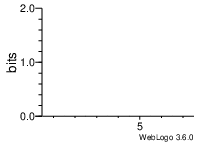

2_PARCLIP_AGO2MNASE_hg19


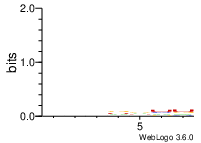

3_HITSCLIP_Ago2_binding_clusters


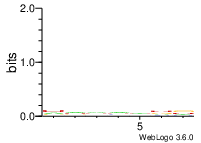

4_HITSCLIP_Ago2_binding_clusters_2


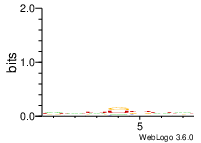

5_CLIPSEQ_AGO2_hg19


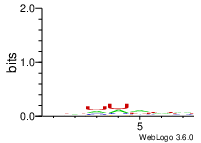

6_CLIP-seq-eIF4AIII_1


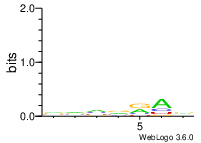

7_CLIP-seq-eIF4AIII_2


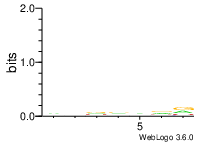

8_PARCLIP_ELAVL1_hg19


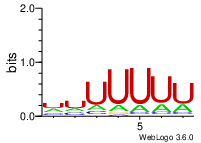

9_PARCLIP_ELAVL1MNASE_hg19


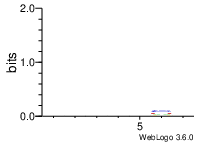

10_PARCLIP_ELAVL1A_hg19


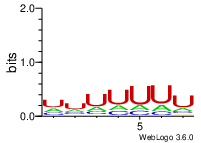

10_PARCLIP_ELAVL1A_hg19


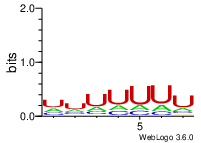

12_PARCLIP_EWSR1_hg19


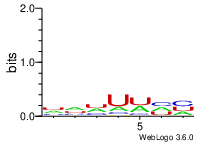

13_PARCLIP_FUS_hg19


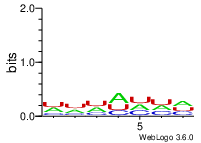

14_PARCLIP_FUS_mut_hg19


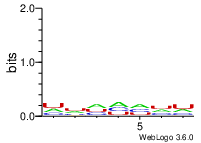

15_PARCLIP_IGF2BP123_hg19


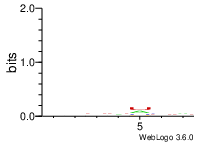

16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


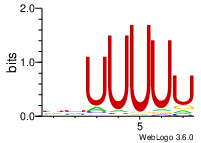

17_ICLIP_HNRNPC_hg19


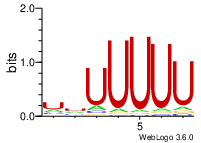

18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


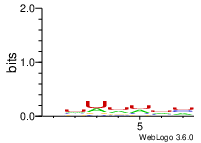

19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


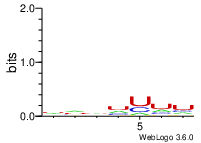

20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


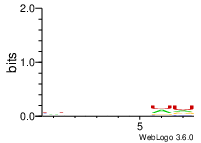

21_PARCLIP_MOV10_Sievers_hg19


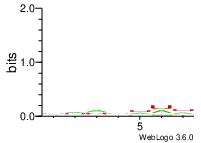

22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


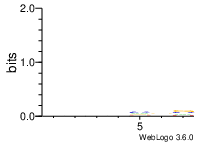

23_PARCLIP_PUM2_hg19


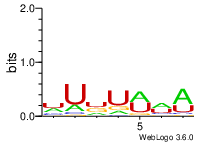

24_PARCLIP_QKI_hg19


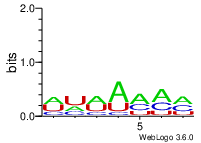

25_CLIPSEQ_SFRS1_hg19


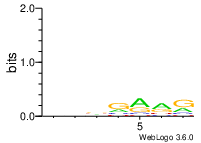

26_PARCLIP_TAF15_hg19


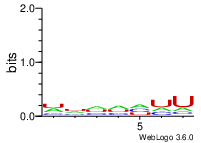

27_ICLIP_TDP43_hg19


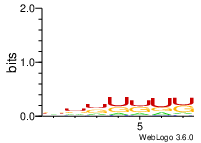

28_ICLIP_TIA1_hg19


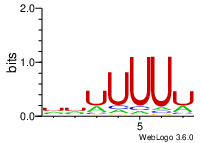

29_ICLIP_TIAL1_hg19


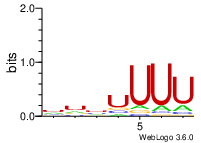

30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


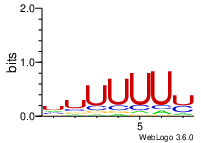

31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


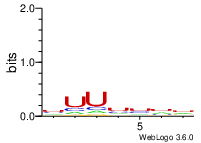

In [3]:
import os
from IPython.display import display, Image

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
training_set_number = 0
for protein in protein_list:
            print (protein)
            cmd = ("weblogo -f results/set_%s/%s/saliency_motifs.txt -D table -F png -o results/set_%s/%s/saliency.png --errorbars NO --show-xaxis YES --show-yaxis YES --size large -A rna --composition none --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U'" % (training_set_number, protein, training_set_number, protein)) 
#             cmd = ("weblogo -f results/set_%s/%s/saliency_motifs.txt -D table -F png -o results/set_%s/%s/saliency.png --errorbars NO --show-xaxis YES --show-yaxis YES -S 0.1 -A rna --composition none --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U'" % (training_set_number, protein, training_set_number, protein))
            os.system(cmd)
            display(Image('results/set_%s/%s/saliency.png' % (training_set_number, protein)))

In [8]:
import h5py
protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
for protein in protein_list:
    #Create a new set for a protein in h5py file  
    with h5py.File("results/set_0/{}/saliency.h5".format(protein), "w") as f:
        dset = f.create_dataset(protein, dtype="f", shape=(0, 101) , maxshape=(None, 101), chunks=(1, 101))
        print(f.keys())

TypeError: Not a location id (invalid object ID)

In [7]:
import h5py
protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
for protein in protein_list:
    print()
with h5py.File("results/set_0/{}/saliency.h5".format(protein), "r") as f:
    f.keys()

()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
